In [109]:
using  Plots, LinearAlgebra, Optim, DataFrames, StatFiles, Distributions, Roots, Random, Interpolations, Printf, QuantEcon, SpecialFunctions


# Markov Chain

In [2]:
function mc_sample_path(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state

    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

mc_sample_path (generic function with 1 method)

In [3]:
std_norm_cdf(x::T) where {T <: Real} = 0.5 * erfc(-x/sqrt(2))
std_norm_cdf(x::Array{T}) where {T <: Real} = 0.5 .* erfc(-x./sqrt(2))

function approx_markov( ρ::Float64, σ::Float64)
    N = 7
    m = 3
    μ = 0
    
    # Get discretized space
    a_bar = m * sqrt(σ^2 / (1 - ρ^2))
    y = range(-a_bar, stop=a_bar, length=N)
    d = y[2] - y[1]

    # Get transition probabilities
    Π = zeros(N, N)
    for row = 1:N
        # Do end points first
        Π[row, 1] = std_norm_cdf((y[1] - ρ*y[row] + d/2) / σ)
        Π[row, N] = 1 - std_norm_cdf((y[N] - ρ*y[row] - d/2) / σ)

        # fill in the middle columns
        for col = 2:N-1
            Π[row, col] = (std_norm_cdf((y[col] - ρ*y[row] + d/2) / σ) -
                           std_norm_cdf((y[col] - ρ*y[row] - d/2) / σ))
        end
    end


    yy = y .+ μ / (1 - ρ) # center process around its mean (wbar / (1 - rho)) in new variable

    # renormalize. In some test cases the rows sum to something that is 2e-15
    # away from 1.0, which caused problems in the MarkovChain constructor
    Π = Π./sum(Π, dims = 2)

    MarkovChain(Π, yy)
end

approx_markov (generic function with 1 method)

In [4]:
Result = Matrix{Tuple}(undef, 2, 4)
for (i,σ) in enumerate([0.1,0.2])
    for (j,ρ) in enumerate([0,0.1,0.3,0.6])
        mc = approx_markov(ρ, σ)
        y = mc_sample_path(mc.p, sample_size = 10^7)
        y = exp.(mc.state_values)[y]
        ρ_markov = abs(round(cov(y[1:end-1],y[2:end]) / var(y); digits=2) )
        σ_markov = round((var(y)*(1-ρ_markov^2))^0.5; digits=2) 
        Result[i,j] = (σ_markov, ρ_markov)
    end
end
Result

2×4 Matrix{Tuple}:
 (0.1, 0.0)   (0.1, 0.1)   (0.11, 0.3)   (0.11, 0.6)
 (0.21, 0.0)  (0.21, 0.1)  (0.22, 0.29)  (0.23, 0.59)

# Bellman iid shocks

In [5]:
function Belman_Operator(IG, grid_z, β, u, prob, l′,ϕ)
    V_function = LinearInterpolation(grid_z,IG, extrapolation_bc=Line())
    objectives = (a′ -> u(z-a′) + β * sum( prob .* V_function.( (1 .+ r).*a′ .+ w .* l′ .- (r*ϕ))) for z in grid_z)
    results = maximize.(objectives, 1e-10, grid_z) # solver result for each grid point
    TV = Optim.maximum.(results) # next W
    g = Optim.maximizer.(results)
    return TV, g
end
function value_function_iteration(IG, grid_z, β, u, N, prob, l′,ϕ)
    V = IG
    for i in 1:N
        res = Belman_Operator(V , grid_z, β, u, prob, l′,ϕ)
        global TV = res[1]
        global g = res[2]
    end
    a′ = g
    return a′
    
end

value_function_iteration (generic function with 1 method)

In [6]:
function DDP(R, Q, Grid, IG, β; ϵ=10^-5) # with shocks and without shocks
    ns = size(R)[1] # number of shocks
    gs = size(R)[2] # grid size
    sup = 1
    One = ones(gs) # 1 vector
    V = repeat(IG.(Grid), 1, ns)' # Value function matrix (Initial guess)
    g = zeros(ns,gs)
    Vc = copy(V)
    while ~(isapprox(sup, 0.0; atol=ϵ, rtol=0))
        for i in 1:ns # T_operator for V1 to Vns
            V[i,:], Argmax = findmax(R[i,:,:] .+ sum([β*Q[i,j]*One*V[j,:]' for j in 1:ns]), dims=2)
            for a in 1:gs
                g[i,a] = Argmax[a][2] # Policy function
            end
        end
        sup = sum((V .- Vc).^2)
        Vc = copy(V)
    end
    P = zeros(ns,gs)
    for i in 1:ns
        for j in 1:gs
            P[i,j] = Grid[Int(g[i,j])]
        end
    end
    return P
end

DDP (generic function with 1 method)

In [7]:
μ = 3
β = 0.94
A = 1.09
N = 100
α = 0.47
δ = 0.09
r = 0.03
b = 1
w = 1
ρ = 0.1
σ = 0.1

grid_min = 0.001
grid_max = 10
n = 200
grid_z = range(grid_min, grid_max, length = n)
N = 100
ϕ=1
ρ = 0.6
σ = 0.4
result = approx_markov(ρ, σ);
prob_min = result.p[1, 1:end]
prob_max = result.p[7, 1:end]
l′ = exp.(result.state_values)
u(c) = log(c)
IG = log.(grid_z);
policy = value_function_iteration(IG, grid_z, β, u, N, prob_max, l′,ϕ);

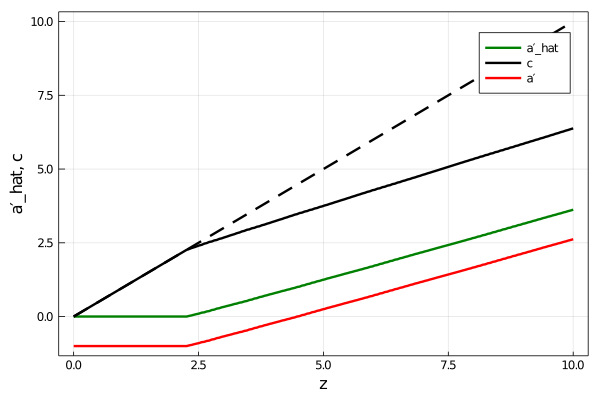

In [8]:
p1 = plot(grid_z, policy, xlabel = "z", ylabel = "a′_hat, c",labels = "a′_hat", c="green", framestyle = :box, fmt = :png, linewidth  = 2)
plot!(grid_z, grid_z .- policy,labels = "c" ,c="black", framestyle = :box, fmt = :png, linewidth  = 2)
plot!(grid_z,  policy .- ϕ ,labels = "a′", c="red", framestyle = :box, fmt = :png, linewidth  = 2)
plot!(grid_z, grid_z ,labels = false, label=false, c="black", framestyle = :box, fmt = :png, style= :dash , linewidth  = 2)

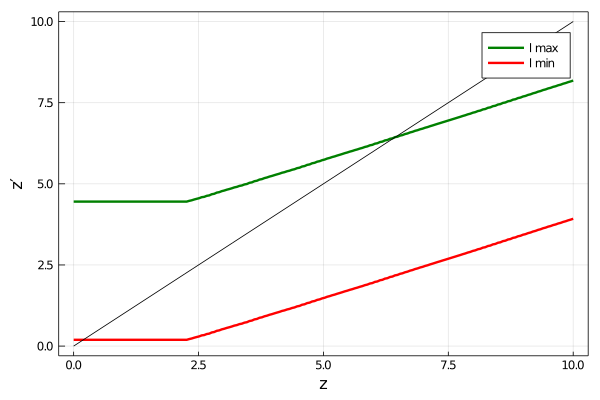

In [9]:
z_max = l′[7] .+ (1+r) .* policy .- r .* ϕ 
z_min = l′[1] .+ (1+r) .* policy .- r .* ϕ 

plot(grid_z, z_max, xlabel = "z", ylabel = "z′",labels = "l max", label=false, c="green", framestyle = :box, fmt = :png, linewidth  = 2)
plot!(grid_z, z_min, xlabel = "z", ylabel = "z′", labels = "l min ", label=false, c="red", framestyle = :box, fmt = :png, linewidth  = 2)
plot!(grid_z, grid_z, labels = false, c="black")

# DDP

In [10]:
function return_function(r, μ, w, ϕ, S, Grid)
    ns = length(S)
    gs = length(Grid)
    R = zeros(ns, gs, gs)
    Rr(a,s,a_prim) = μ == 1 ? log((1+r)*a + w*s - a_prim) : (((1+r)*a + w*s - a_prim)^(1-μ))/(1-μ)
    for i in 1:ns
        for j in 1:gs
            for k in 1:gs
                R[i,j,k] = ((1+r)*Grid[j] + w*S[i] - Grid[k])>=0 ? Rr(Grid[j],S[i],Grid[k]) : -10^9
            end
        end
    end
    return R
end

return_function (generic function with 1 method)

In [11]:
function discrete_prob(array)
    cumulative_prob = cumsum(array)
    rr = rand()
    return findall(x->x==(cumulative_prob[cumulative_prob .>= rr][1]), cumulative_prob)[1]
end

discrete_prob (generic function with 1 method)

# Stationary distribution

In [12]:
β = 0.94
δ = 0.09
α = 0.47
μ = 1
A = 1.09
ϕ = 0
N = 200
Grid = range(0, 20, N)
ns = 7



function Policy(r, ρ, σ, μ)
    w = A * (1 - α) * (A * α / (r + δ))^(α / (1 - α))
    mc = approx_markov(ρ, σ);
    S = exp.(mc.state_values)
    Q = mc.p
    R = return_function(r, μ, w, ϕ, S, Grid)
    IG(x) = x
    return DDP(R, Q, Grid, IG, β)
end



function Ea(r, ρ, σ, μ)
    m = 0
    m′ = 0
    N = 10^5
    pol = []
    mc = approx_markov(ρ, σ);
    S = exp.(mc.state_values)
    Q = mc.p
    for i in 1:ns
        push!(pol, LinearInterpolation(Grid, Policy(r, ρ, σ, μ)[i,:]))
    end
    a_list = zeros(N)
    a′_list = zeros(N)
    l_list = zeros(N)
    l′_list = zeros(N)
    l′_list[1:end] = rand(1:ns,N)
    a_list[1:end] = Grid[rand(DiscreteUniform(1,length(Grid)), N)]
    sup = 1
    while ~(isapprox(sup, 0.0; atol=10^-4, rtol=0))
        m = mean(a_list)
        for i in 1:N
            a′_list[i] = pol[Int(l′_list[i])](a_list[i])
            l_list[i] = copy(l′_list[i])
            l′_list[i] = discrete_prob(Q[Int(l_list[i]),:])
            a_list[i] = copy(a′_list[i])
        end
        m′ = mean(a_list)
        sup = abs(m-m′)
    end
    return m′, a_list
end

Ea (generic function with 1 method)

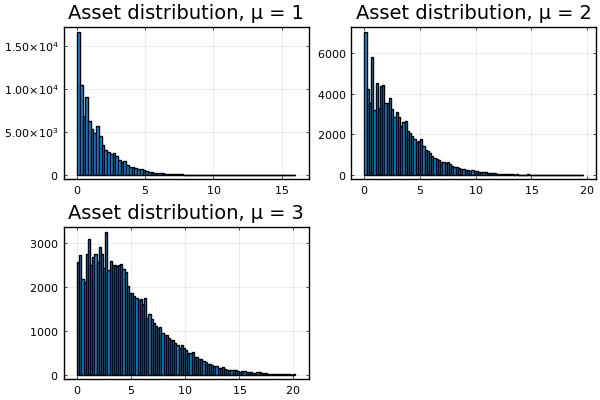

In [8]:
plots = []
for μ in 1:3
    p = histogram(Ea(0.05, 0.6, 0.2, μ)[2], bins=100, title="Asset distribution, μ = $μ")
    push!(plots, p)
end
plot(plots..., legend=false, framestyle = :box)

# General Equalibrium

In [13]:
# Demabd for capital
function rk(k)
    A * α * (1 / k)^(1 - α) - δ
end


function kr(r)
    ((r+δ)/(A*α))^(1/(α-1))
end

# General Equilibrium function
# Input: 
# Serial correlation in earning(ρ), 
# Coefficient of variation of earnings(σ) and
# Relative risk aversion coefficient(μ)
# Output:
# Net return to capital in equilibrium
function GE(ρ, σ, μ)
    r1 = 1/β - 1 - 0.000001
    ea1 = Ea(r1, ρ, σ, μ)
    r2 = rk(ea1)
    sup = abs(r2 - r1)
    r3 = (r2 + r1)/2
    while ~(isapprox(sup, 0.0; atol=10^-3, rtol=0))
        ea3 = Ea(r3, ρ, σ, μ)
        k3 = kr(r3)
        if k3 < ea3
            r1 = copy(r3)
        else
            r2 = copy(r3)
        end
        sup = abs(r2 - r1)
        r3 = (r2 + r1)/2
    end
    return r3
end

GE (generic function with 1 method)

In [125]:
GE(0.6, 0.4, 1)

0.06165346486020473

In [9]:
Eas1 = []
Eas3 = []
Eas5 = []
ρ = 0.6
σ = 0.2
@time begin
    for rr in range(0.0001, 1/β - 1 - 0.001, 40)
        push!(Eas1, Ea(rr, ρ, σ, 1))
    end
end

1346.517369 seconds (11.12 G allocations: 1.437 TiB, 12.56% gc time, 0.00% compilation time)


In [10]:
ρ = 0.6
σ = 0.2
@time begin
    for rr in range(0.0001, 1/β - 1 - 0.001, 40)
        push!(Eas3, Ea(rr, ρ, σ, 3))
    end
end

1855.897160 seconds (17.80 G allocations: 1.877 TiB, 12.03% gc time)


In [11]:
ρ = 0.6
σ = 0.2
@time begin
    for rr in range(0.0001, 1/β - 1 - 0.001, 40)
        push!(Eas5, Ea(rr, ρ, σ, 5))
    end
end

2073.795573 seconds (20.84 G allocations: 2.036 TiB, 12.07% gc time)


In [70]:
EA1 = zeros(40)
EA3 = zeros(40)
EA5 = zeros(40)
for i in 1:40
    EA1[i] = Eas1[i][1]
    EA3[i] = Eas3[i][1]
    EA5[i] = Eas5[i][1]
end

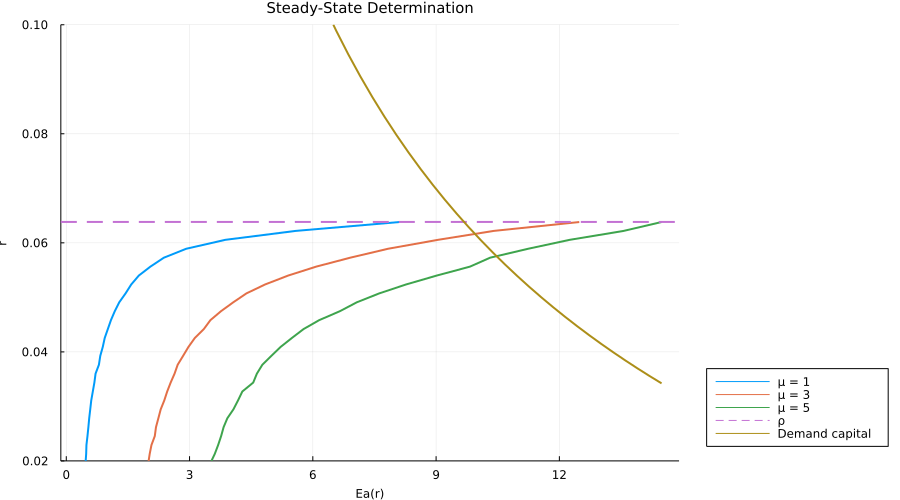

In [72]:
gr(fmt = :png, size = (900, 500))
ρ = 1/β - 1
p1 = plot(hcat(EA1, EA3, EA5), range(0.00001, 1/β - 1 - 0.00001, 40), label = ["μ = 1" "μ = 3" "μ = 5"], title = "Steady-State Determination", lw = 2, titlefontsize=10, guidefontsize=8, legend_position=:outerbottomright)
plot!(p1,[ρ], seriestype="hline", linestyle = :dash, label="ρ" ,lw = 2, titlefontsize=10, guidefontsize=8)
plot!(p1, range(EA5[1], EA5[end], 40), rk.(range(EA5[1], EA5[end], 40)), lw = 2, ylim=(0.02,0.1), label = "Demand capital")
xlabel!("Ea(r)")
ylabel!("r")

# Result

In [14]:
function Outputs(r, ρ, σ, μ)
    m = 0
    m′ = 0
    N = 10^5
    pol = []
    mc = approx_markov(ρ, σ);
    S = exp.(mc.state_values)
    Q = mc.p
    for i in 1:ns
        push!(pol, LinearInterpolation(Grid, Policy(r, ρ, σ, μ)[i,:]))
    end
    c_list = zeros(N)
    ni_list = zeros(N)
    gi_list = zeros(N)
    gs_list = zeros(N)
    a_list = zeros(N)
    a′_list = zeros(N)
    l_list = zeros(N)
    l′_list = zeros(N)
    l′_list[1:end] = rand(1:ns,N)
    a_list[1:end] = Grid[rand(DiscreteUniform(1,length(Grid)), N)]
    sup = 1
    while ~(isapprox(sup, 0.0; atol=10^-4, rtol=0))
        m = mean(a_list)
        for i in 1:N
            a′_list[i] = pol[Int(l′_list[i])](a_list[i])
            l_list[i] = copy(l′_list[i])
            l′_list[i] = discrete_prob(Q[Int(l_list[i]),:])
            a_list[i] = copy(a′_list[i])
        end
        m′ = mean(a_list)
        sup = abs(m-m′)
    end
    for i in 1:N
        a′_list[i] = pol[Int(l′_list[i])](a_list[i])
    end
    w = A * (1 - α) * (A * α / (r + δ))^(α / (1 - α))
    c_list = w .* l′_list .+ (1+r) .* a_list .- a′_list
    ni_list = w .* l′_list .+ r .* a_list
    gi_list = ni_list .+ (δ .* a_list)
    gs_list = gi_list .- c_list
    return a′_list, c_list, ni_list, gi_list, gs_list
end

Outputs (generic function with 1 method)

In [15]:
r = 0.06356810470771929
ρ = 0.3
σ = 0.2
μ = 1
out1 = Outputs(r, ρ, σ, μ);

In [16]:
r = 0.061983965613076716
ρ = 0.3
σ = 0.2
μ = 3
out2 = Outputs(r, ρ, σ, μ);

In [17]:
r = 0.06022965204267519
ρ = 0.3
σ = 0.2
μ = 5
out3 = Outputs(r, ρ, σ, μ);

In [18]:
r = 0.06331203579276941
ρ = 0.6
σ = 0.2
μ = 1
out4 = Outputs(r, ρ, σ, μ);

In [19]:
r = 0.06078151500129067
ρ = 0.6
σ = 0.2
μ = 3
out5 = Outputs(r, ρ, σ, μ);

In [20]:
r = 0.056729966833464866
ρ = 0.6
σ = 0.2
μ = 5
out6 = Outputs(r, ρ, σ, μ);

In [21]:
r = 0.06041760269564426
ρ = 0.9
σ = 0.2
μ = 1
out7 = Outputs(r, ρ, σ, μ);

In [22]:
r = 0.045795974998536486
ρ = 0.9
σ = 0.2
μ = 3
out8 = Outputs(r, ρ, σ, μ);

In [23]:
r = 0.03351000131012986
ρ = 0.9
σ = 0.2
μ = 5
out9 = Outputs(r, ρ, σ, μ);

In [24]:
r = 0.06310072134909493
ρ = 0.3
σ = 0.4
μ = 1
out10 = Outputs(r, ρ, σ, μ);

In [25]:
r = 0.05895751525472953
ρ = 0.3
σ = 0.4
μ = 3
out11 = Outputs(r, ρ, σ, μ);

In [26]:
r = 0.0530557943684963
ρ = 0.3
σ = 0.4
μ = 5
out12 = Outputs(r, ρ, σ, μ);

In [27]:
r = 0.06206864945041453
ρ = 0.6
σ = 0.4
μ = 1
out13 = Outputs(r, ρ, σ, μ);

In [28]:
r = 0.05243338701469502
ρ = 0.6
σ = 0.4
μ = 3
out14 = Outputs(r, ρ, σ, μ);

In [29]:
r = 0.042505217973194176
ρ = 0.6
σ = 0.4
μ = 5
out15 = Outputs(r, ρ, σ, μ);

In [30]:
r = 0.05483499808375618
ρ = 0.9
σ = 0.4
μ = 1
out16 = Outputs(r, ρ, σ, μ);

In [31]:
r = 0.03217176040840679
ρ = 0.9
σ = 0.4
μ = 3
out17 = Outputs(r, ρ, σ, μ);

In [32]:
r = 0.023184794983528555
ρ = 0.9
σ = 0.4
μ = 5
out18 = Outputs(r, ρ, σ, μ);

In [45]:
# calculate Coefficient of variation
function CV(data)
    cv_a  = round(std(data[1]) / mean(data[1]),digits = 3)
    cv_c  = round(std(data[2]) / mean(data[2]),digits = 3)
    cv_ni = round(std(data[3]) / mean(data[3]),digits = 3)
    cv_gi = round(std(data[4]) / mean(data[4]),digits = 3)
    cv_gs = round(std(data[5]) / mean(data[5]),digits = 3)
    
   return  cv_c, cv_ni, cv_gi, cv_gs, cv_a
end

CV (generic function with 1 method)

In [65]:
println(" (consumption, net income, gross income, gross saving, assets)")

 (consumption, net income, gross income, gross saving, assets)


In [46]:
CV(out1)

(0.196, 0.239, 0.223, 0.484, 0.388)

In [47]:
CV(out2)

(0.201, 0.244, 0.238, 0.641, 0.545)

In [48]:
CV(out3)

(0.198, 0.242, 0.227, 0.527, 0.406)

In [49]:
CV(out4)

(0.202, 0.251, 0.246, 0.688, 0.535)

In [50]:
CV(out5)

(0.206, 0.251, 0.248, 0.672, 0.554)

In [51]:
CV(out6)

(0.203, 0.251, 0.244, 0.644, 0.499)

In [52]:
CV(out7)

(0.26, 0.296, 0.311, 0.802, 0.658)

In [53]:
CV(out8)

(0.256, 0.291, 0.296, 0.651, 0.51)

In [54]:
CV(out9)

(0.258, 0.288, 0.281, 0.501, 0.376)

In [55]:
CV(out10)

(0.16, 0.246, 0.238, 0.96, 0.511)

In [56]:
CV(out11)

(0.159, 0.244, 0.235, 0.913, 0.485)

In [57]:
CV(out12)

(0.159, 0.245, 0.232, 0.875, 0.437)

In [58]:
CV(out13)

(0.177, 0.256, 0.257, 1.04, 0.56)

In [59]:
CV(out14)

(0.177, 0.255, 0.251, 0.953, 0.493)

In [60]:
CV(out15)

(0.178, 0.256, 0.244, 0.834, 0.392)

In [61]:
CV(out16)

(0.268, 0.303, 0.323, 1.011, 0.643)

In [62]:
CV(out17)

(0.26, 0.289, 0.285, 0.628, 0.375)

In [63]:
CV(out18)

(0.265, 0.285, 0.265, 0.42, 0.238)